In [1]:
# Base import and functions

import imutils
import cv2
from imutils import contours
import os, os.path

from tqdm import tqdm

import pytesseract             # Python interface to tesseract for OCR

import numpy as np
from PIL import Image

from skimage.color import rgb2gray
from skimage.exposure import equalize_adapthist, adjust_log
from skimage.restoration import denoise_tv_chambolle, denoise_wavelet, denoise_bilateral
from skimage.filters import threshold_niblack
from skimage.util import img_as_float, img_as_ubyte, img_as_uint
from skimage.morphology import reconstruction
from skimage.morphology import remove_small_objects, remove_small_holes
from skimage.morphology import disk, diamond, square
from skimage.filters import rank
from skimage.filters import threshold_mean, threshold_local
from skimage.morphology import erosion, dilation, opening, closing, binary_opening, binary_closing, binary_dilation, binary_erosion

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%load_ext line_profiler

import skimage
print("skimage: " + skimage.__version__)  # Must be greater then 0.14 for Chain Vesa

skimage: 0.14dev


## Segmentation helpers

In [2]:
def crop_number(input_src):
    return input_src[310:310+100, 300:300+330]

def projectionVer(input_img):
    return np.sum(input_img, axis=1)/255

def projectionHor(input_img):
    return np.sum(input_img, axis=0)/255

def threshold(input_img):
    # gray = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=3.5, tileGridSize=(8,8))
    clh = clahe.apply(cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY))
   
    _, trunc = cv2.threshold(clh, 100, 255, cv2.THRESH_TRUNC)
    blurred = cv2.bilateralFilter(trunc, 6, 25, 25)
    return cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 5)

def segment_number(excise_src):
    
    number = crop_number(excise_src)
    thresholded = threshold(number)

    refCnts = cv2.findContours(thresholded.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[1]

    good_mask = np.ones(thresholded.shape[:2], dtype="uint8") * 0
    good_mask_candidates = []

    for c in refCnts:
        (x, y, w, h) = cv2.boundingRect(c)
        if (w < 100) and (h > 10) and (w > 5) and (h < 90):
            good_mask_candidates.append((x, y, w, h))
            cv2.drawContours(good_mask, [c], -1, 255, -1)

    verp = projectionVer(good_mask)
    peak = np.amax(verp)
    topline = 0
    bottomline = 0
    for i in range(len(verp)):
        if verp[i] > peak*0.5:
            if topline == 0:
                topline = i-1
            if bottomline < i+1:
                bottomline = i+1

    leftline = 0
    rightline = 0
    for (x, y, w, h) in good_mask_candidates:
        if ((y+h > topline) or (y < bottomline)) and (topline - y < 20) and (y+h - bottomline < 20) and (w*h > 200):
            if (leftline == 0) or (x < leftline):
                leftline = x
            if rightline < x+w:
                rightline = x+w


    topline = topline-8 if topline > 8 else 0
    bottomline = bottomline+4 if bottomline < 96 else 100
    leftline = leftline-8 if leftline > 8 else 0
    rightline = rightline+16 if rightline < 314 else 330
    
    # For correct orientation <--- !!!!!!
    # topline = topline-4 if topline > 4 else 0
    # bottomline = bottomline+8 if bottomline < 92 else 100
    # leftline = leftline-16 if leftline > 16 else 0
    # rightline = rightline+8 if rightline < 322 else 330

    # For Visualisation
    # cv2.rectangle(number, (int(leftline), int(topline)), (int(rightline), int(bottomline)), (255, 0, 0), 2)
    
    return int(leftline), int(topline), int(rightline), int(bottomline)

## Visualization helpers

In [3]:
def display_single_tests():
    fig, ax = plt.subplots(3, 4, figsize=(40, 10), sharex=True, sharey=True)
    ax = ax.ravel()

    ax[0].imshow(cv2.cvtColor(number, cv2.COLOR_BGR2RGB))
    ax[0].set_title('Original image')
    ax[0].axis('off')

    ax[1].imshow(cv2.cvtColor(clh, cv2.COLOR_GRAY2RGB))
    ax[1].set_title('Histograms Equalization')
    ax[1].axis('off')
    
    ax[2].imshow(cv2.cvtColor(trunc, cv2.COLOR_GRAY2RGB))
    ax[2].set_title('Truncated')
    ax[2].axis('off')
    
    ax[3].imshow(cv2.cvtColor(thresholded, cv2.COLOR_GRAY2RGB))
    ax[3].set_title('Thresholded')
    ax[3].axis('off')
    
    ax[4].imshow(cv2.cvtColor(masked_thres, cv2.COLOR_GRAY2RGB))
    ax[4].set_title('contours_filtered')
    ax[4].axis('off')
    
    ax[5].imshow(cv2.cvtColor(thres2, cv2.COLOR_GRAY2RGB))
    ax[5].set_title('equ2')
    ax[5].axis('off')
    
    ax[6].imshow(cv2.cvtColor(bordered, cv2.COLOR_GRAY2RGB))
    ax[6].set_title('Bordered')
    ax[6].axis('off')
    
    ax[7].imshow(cv2.cvtColor(connected, cv2.COLOR_GRAY2RGB))
    ax[7].set_title('Connected')
    ax[7].axis('off')
    
    ax[8].imshow(cv2.cvtColor(contours, cv2.COLOR_BGR2RGB))
    ax[8].set_title('contours')
    ax[8].axis('off')

    ax[9].imshow(cv2.cvtColor(cleared, cv2.COLOR_GRAY2RGB))
    ax[9].set_title('Cleared')
    ax[9].axis('off')
    
    ax[10].imshow(cv2.cvtColor(graphicHor, cv2.COLOR_GRAY2RGB))
    ax[10].set_title('graphicHor')
    ax[10].axis('off')
    
    ax[11].imshow(cv2.cvtColor(graphicVer, cv2.COLOR_GRAY2RGB))
    ax[11].set_title('graphicVer')
    ax[11].axis('off')

## Recognition

In [4]:
# excise_src = cv2.imread("data/monitor/_1521540786569_capture.png")
# excise_src = cv2.imread("data/monitor/_1521540617554_capture.png")
# excise_src = cv2.imread("data/monitor/_1521540627629_capture.png")
# excise_src = cv2.imread("data/monitor/_1521540917583_capture.png")

# excise_src = cv2.imread("data/monitor/_1521541525082_capture.png")
# excise_src = cv2.imread("data/monitor/_1521540642840_capture.png")

excise_src = cv2.imread("data/monitor/_1521540926209_capture.png")

# excise_src = cv2.imread("data/monitor/_1521540978090_capture.png")
# excise_src = cv2.imread("data/monitor/_1521540979637_capture.png") #<--

# excise_src = cv2.imread("data/monitor/_1521540643837_capture.png")
# excise_src = cv2.imread("data/monitor/_1521540628560_capture.png")
# excise_src = cv2.imread("data/monitor/_1521540613851_capture.png")
# excise_src = cv2.imread("data/monitor/_1521540617554_capture.png")

CPU times: user 2.5 ms, sys: 565 µs, total: 3.07 ms
Wall time: 2.32 ms
CPU times: user 13 ms, sys: 1.93 ms, total: 14.9 ms
Wall time: 706 ms
405111 2388


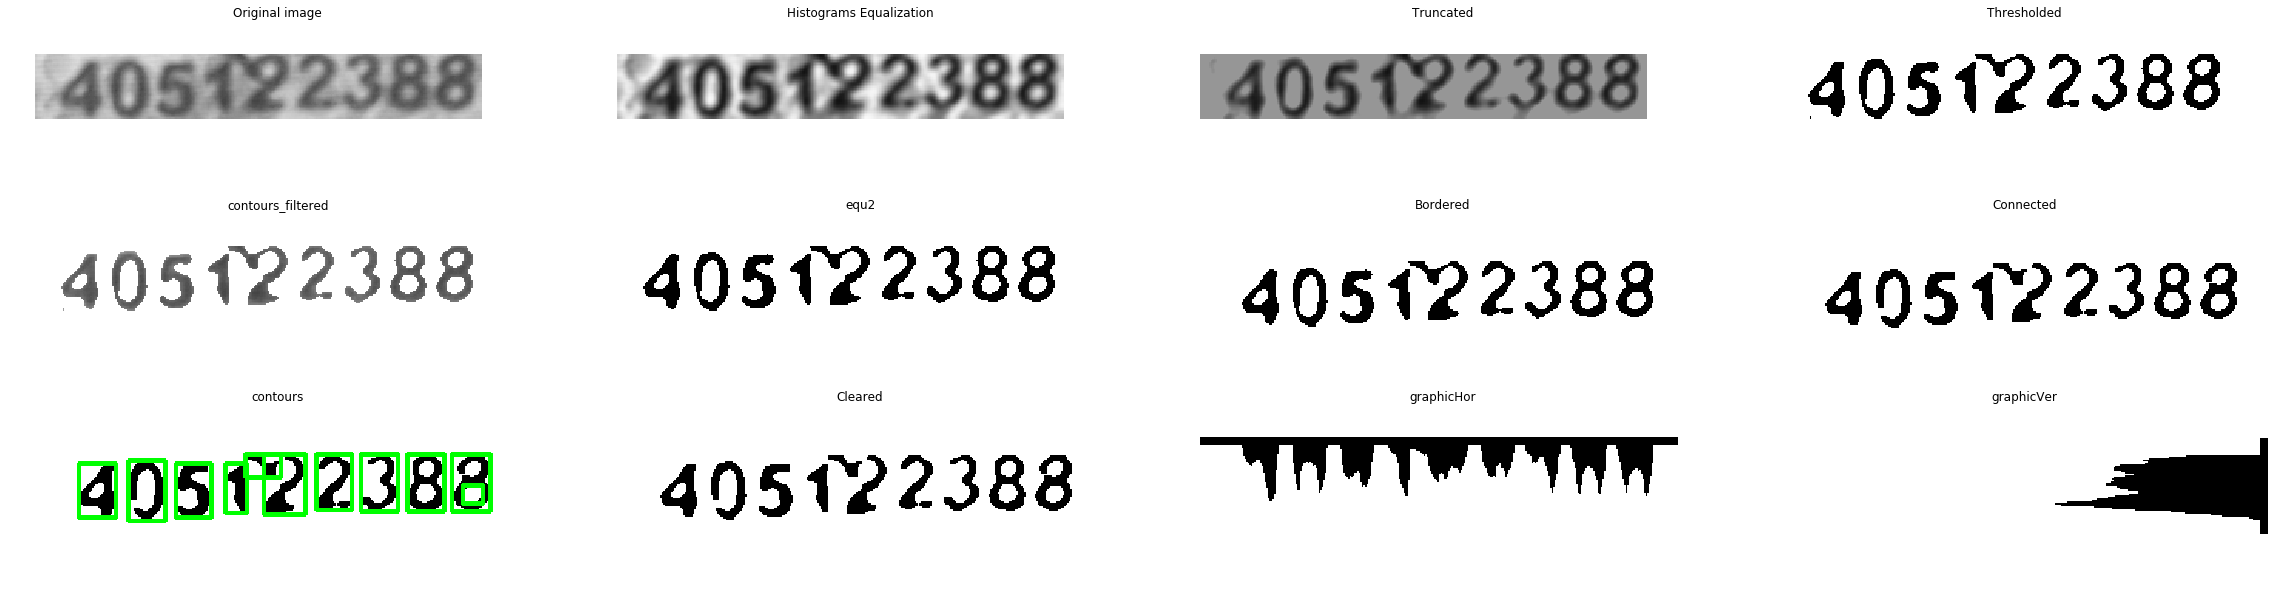

In [5]:
%time leftline, topline, rightline, bottomline = segment_number(excise_src)

number = excise_src[310+topline:310+bottomline, 300+leftline:300+rightline]

(h, w) = number.shape[:2]
center = (w / 2, h / 2)
 
# rotate the image by 180 degrees
M = cv2.getRotationMatrix2D(center, 180, 1.0)
number = cv2.warpAffine(number, M, (w, h))
# remove black border after Affine rotation
number = number[1:h-2, 1:w-2]
gray = cv2.cvtColor(number, cv2.COLOR_BGR2GRAY)

#equ = cv2.equalizeHist(cv2.cvtColor(number, cv2.COLOR_BGR2GRAY))
#equ = cv2.bilateralFilter(equ, 6, 35, 35)

clahe = cv2.createCLAHE(clipLimit=3.5, tileGridSize=(8,8))
clh = clahe.apply(cv2.cvtColor(number, cv2.COLOR_BGR2GRAY))
# clh = cv2.bilateralFilter(clh, 6, 15, 15)
clh = cv2.GaussianBlur(clh,(5,5),0)

_, trunc = cv2.threshold(clh, 150, 255, cv2.THRESH_TRUNC)
thresholded = cv2.adaptiveThreshold(trunc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 101, 29)

masked_thres = cv2.add(gray, thresholded)
(minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(masked_thres)
_, thres2 = cv2.threshold(masked_thres, minVal+70, 255, cv2.THRESH_BINARY)

bordered = cv2.copyMakeBorder(thres2, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=[255,255,255])

#kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
#connected = cv2.morphologyEx(bordered, cv2.MORPH_CLOSE, kernel)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 2))
connected = cv2.morphologyEx(bordered, cv2.MORPH_CLOSE, kernel)
# connected = cv2.morphologyEx(bordered, cv2.MORPH_CLOSE, kernel)

# For visualization
contours = cv2.cvtColor(connected.copy(), cv2.COLOR_GRAY2BGR)
cleared = connected.copy()
edged = cv2.Canny(connected.copy(), 30, 200)
refCnts = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
for c in refCnts:
    (x, y, w, h) = cv2.boundingRect(c)
    if (((w > 8) and (h > 8)) or (w*h > 100)) and (w / h < 15) and (h / w < 15):
        # For visualization
        cv2.rectangle(contours, (x, y), (x + w, y + h), (0, 255, 0), 2)
    else:
        cv2.drawContours(cleared, [c], -1, 255, 7)
        # For visualization
        cv2.rectangle(contours, (x, y), (x + w, y + h), (0, 0, 255), 2)

# For Visualisation
horp = projectionHor(bordered)
    
horp2 = horp.astype(int)
h = int(np.max(horp2) + 5)
graphicHor = np.zeros((h, bordered.shape[1]), dtype = "uint8")

for i in range(len(horp2)):
    graphicHor[int(graphicHor.shape[0]-horp2[i]):graphicHor.shape[0], i] = 255
    
verp = projectionVer(connected)

verp2 = verp.astype(int)
w = np.max(verp2) + 5
graphicVer = np.zeros((connected.shape[0], w), dtype = "uint8")

for i in range(len(verp2)):
    graphicVer[i, 0:verp2[i]] = 255

%time number_candidate = pytesseract.image_to_string(Image.fromarray(bordered, "L"), config="--tessdata-dir ./tessdata -psm 8 -l eng -c tessedit_char_whitelist=1234567890 nobatch digits")

display_single_tests()
print(number_candidate)

## Tests

In [154]:
def binarise_number(leftline, topline, rightline, bottomline, excise_src):
    
    number = excise_src[310+topline:310+bottomline, 300+leftline:300+rightline]

    (h, w) = number.shape[:2]
    center = (w / 2, h / 2)

    # rotate the image by 180 degrees
    M = cv2.getRotationMatrix2D(center, 180, 1.0)
    number = cv2.warpAffine(number, M, (w, h))
    
    # remove black border after Affine rotation
    number = number[1:h-2, 1:w-2]
    gray = cv2.cvtColor(number, cv2.COLOR_BGR2GRAY)

    #equ = cv2.equalizeHist(cv2.cvtColor(number, cv2.COLOR_BGR2GRAY))
    #equ = cv2.bilateralFilter(equ, 6, 35, 35)

    clahe = cv2.createCLAHE(clipLimit=3.5, tileGridSize=(8,8))
    clh = clahe.apply(cv2.cvtColor(number, cv2.COLOR_BGR2GRAY))
    # clh = cv2.bilateralFilter(clh, 6, 15, 15)
    clh = cv2.GaussianBlur(clh,(5,5),0)

    _, trunc = cv2.threshold(clh, 150, 255, cv2.THRESH_TRUNC)
    thresholded = cv2.adaptiveThreshold(trunc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 101, 29)

    masked_thres = cv2.add(gray, thresholded)
    (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(masked_thres)
    _, thres2 = cv2.threshold(masked_thres, minVal+70, 255, cv2.THRESH_BINARY)

    bordered = cv2.copyMakeBorder(thres2, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=[255,255,255])
    number_candidate = pytesseract.image_to_string(Image.fromarray(bordered, "L"), config="--tessdata-dir ./tessdata -psm 8 -l eng -c tessedit_char_whitelist=1234567890 nobatch digits")
            
    return bordered, number_candidate

100%|██████████| 146/146 [00:25<00:00,  5.81it/s]


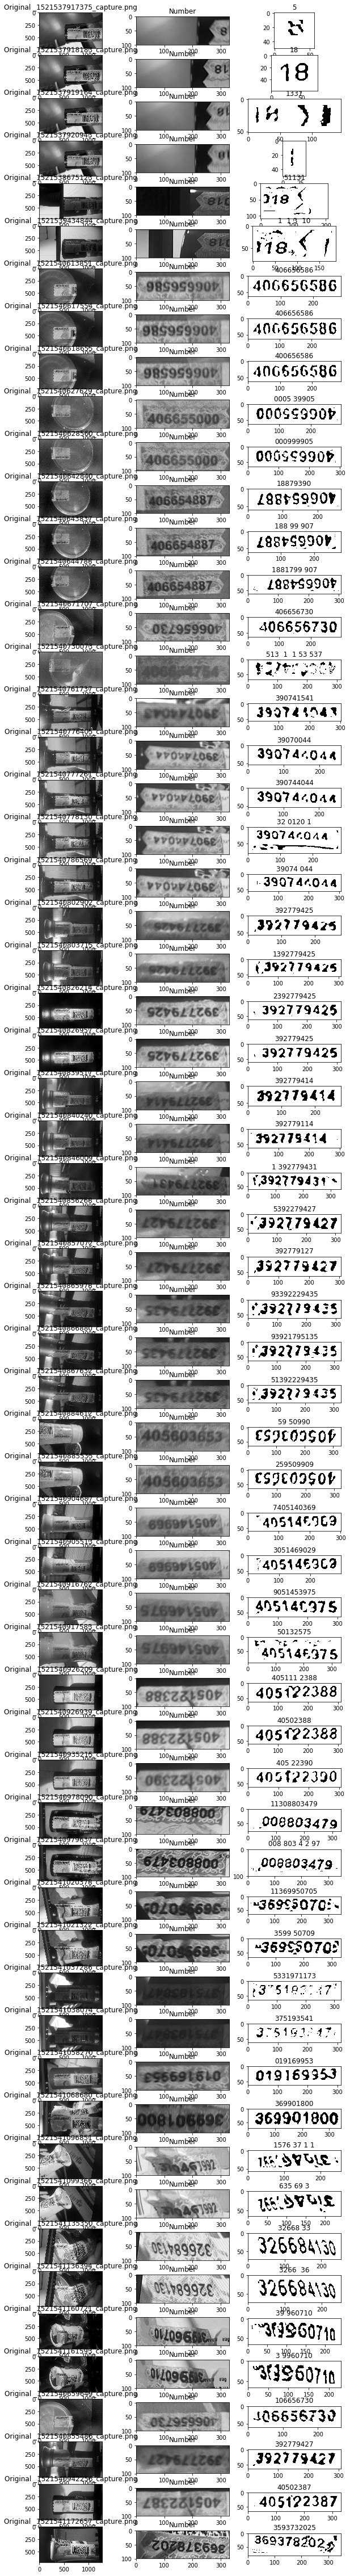

In [155]:
DIR = 'data/monitor'
filescount = len([name for name in os.listdir(DIR) if (name.endswith(".PNG") or name.endswith(".png"))])
current_file_index = 0
fig = plt.figure(figsize=(10, 200))

for filename in tqdm(os.listdir(DIR)):
    if (not (filename.endswith(".PNG") or filename.endswith(".png"))) or (current_file_index > 60):
        current_file_index += 1
        continue

    current_excise_src = cv2.imread(os.path.join(DIR, filename))

    leftline, topline, rightline, bottomline = segment_number(current_excise_src)
    number, number_candidate = binarise_number(leftline, topline, rightline, bottomline, current_excise_src)
    croped_number = crop_number(current_excise_src)

    a = fig.add_subplot(filescount, 3, 3 * current_file_index + 1)
    imgplot = plt.imshow(cv2.cvtColor(current_excise_src, cv2.COLOR_BGR2RGB))
    a.set_title('Original ' + filename)

    a = fig.add_subplot(filescount, 3, 3 * current_file_index + 2)
    imgplot = plt.imshow(cv2.cvtColor(croped_number, cv2.COLOR_BGR2RGB))
    a.set_title('Number')
    
    a = fig.add_subplot(filescount, 3, 3 * current_file_index + 3)
    imgplot = plt.imshow(cv2.cvtColor(number, cv2.COLOR_GRAY2RGB))
    a.set_title(number_candidate)
    
    current_file_index += 1

plt.show()